# Modélisation du prix des maisons

Ce notebook documente l'ensemble du flux de travail : exploration des données, préparation, entraînement de modèles réutilisable pour l'application Streamlit.

## 1. Importation des librairies et configuration
Nous commençons par charger les packages nécessaires pour l'analyse exploratoire et la modélisation.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Chargement des données
Nous utilisons les fichiers `train.csv` et `test.csv` fournis. La variable cible est `SalePrice` dans l'échantillon d'entraînement.

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.shape, test_df.shape

((1460, 81), (1459, 80))

## 3. Aperçu des données
Un premier coup d'œil sur les colonnes principales permet d'identifier rapidement la structure du jeu de données.

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.describe(include='all').transpose().iloc[:15]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Données manquantes
Nous calculons le pourcentage de valeurs manquantes par colonne et visualisons les variables les plus touchées.

In [4]:
missing_ratio = (train_df.isnull().mean() * 100).sort_values(ascending=False)
missing_ratio.head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
dtype: float64

In [7]:
# Suppression immédiate des colonnes avec trop de valeurs manquantes (>50%)
threshold = len(train_df) * 0.5
train_df = train_df.dropna(thresh=threshold, axis=1)

# Suppression des colonnes non-pertinentes identifiées
cols_to_drop = ['Id', 'MSSubClass', 'MSZoning']
train_df = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns])

print(f"Format des données après nettoyage initial : {train_df.shape}")

Format des données après nettoyage initial : (1460, 73)


## 5. Analyse de la variable cible
`SalePrice` présente une distribution asymétrique ; nous observons également sa version log-transformée pour stabiliser la variance.

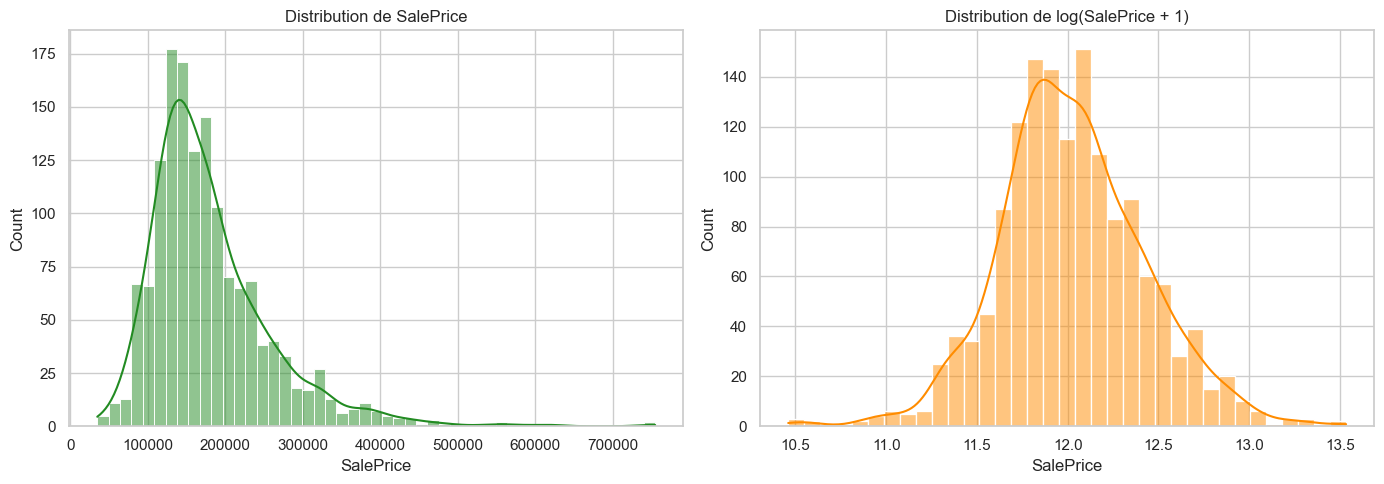

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['SalePrice'], kde=True, ax=axes[0], color='forestgreen')
axes[0].set_title('Distribution de SalePrice')
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Distribution de log(SalePrice + 1)')
plt.tight_layout()

## 6. Fonctions de Prétraitement

In [ ]:
def preprocess_data(df_input):
    train_df = df_input.copy()
    
    # 1. Mapping Ordinal (Expertise Métier)
    mappings = {
        "BsmtQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    }
    for col, mapping in mappings.items():
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna(0).replace(mapping).astype(int)
            
    # 2. Imputation des valeurs manquantes restantes
    fill_values = {
        "LotFrontage": train_df["LotFrontage"].median() if "LotFrontage" in train_df.columns else 0,
        "MasVnrArea": 0,
        "GarageYrBlt": 0,
        "Electrical": train_df["Electrical"].mode()[0] if "Electrical" in train_df.columns else "Unknown"
    }
    for col, val in fill_values.items():
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna(val)
            
    return train_df

train_df = preprocess_data(train_df)

## 7. Corrélations avec la cible
Nous observons les variables numériques les plus corrélées avec `SalePrice` pour guider l'interprétation.

C:\Users\Republic Of Computer\AppData\Local\Temp\ipykernel_11352\3634296844.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


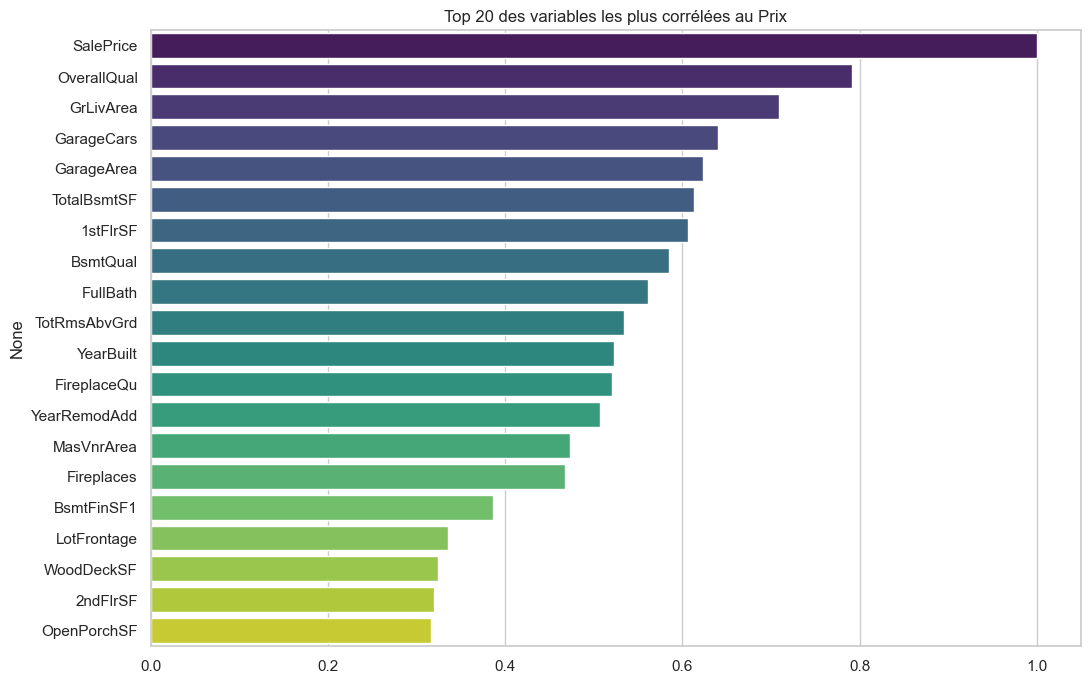

In [18]:
plt.figure(figsize=(12, 8))
top_corr = train_df.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False).head(20)
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 20 des variables les plus corrélées au Prix')
plt.show()

## 8. Encodage et Split

L'Encodage (OneHot) et la séparation entre `X` et `y` est réalisée avant la division en apprentissage/test.

In [11]:
# Séparation Cible/Features
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]

# Identification des colonnes catégorielles
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Encodage (OneHot)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded_raw = encoder.fit_transform(X[cat_cols])
X_encoded_df = pd.DataFrame(X_encoded_raw, columns=encoder.get_feature_names_out(cat_cols))

# Recomposition du DataFrame final
X_final = pd.concat([X.select_dtypes(exclude=['object']).reset_index(drop=True), 
                     X_encoded_df.reset_index(drop=True)], axis=1)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Sauvegarde de la liste des colonnes pour Streamlit
# with open("features_list.pkl", "wb") as f:
#     pickle.dump(X_final.columns.tolist(), f)

## 10. Modèle 1 : Random Forest Regressor
Forêt aléatoire robuste aux relations non linéaires et interactions. Nous évaluons ses performances sur l'échantillon de validation.

In [14]:
rf_model = RandomForestRegressor(n_estimators=400, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest - R2 Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest - MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")

Random Forest - R2 Score: 0.8937
Random Forest - MAE: 17408.77


## 11. Modèle 2 : XGBoost Regressor
Gradient boosting performant sur données tabulaires. Les hyperparamètres sont calibrés pour un bon compromis biais/variance.

In [20]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost - R2 Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost - MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")

# Sauvegarde du meilleur modèle
joblib.dump(xgb_model, "mon_deuxieme_model.joblib")

XGBoost - R2 Score: 0.9139
XGBoost - MAE: 16031.27


['mon_deuxieme_model.joblib']

## 13. Importance des variables du meilleur modèle
Nous extrayons les importances issues du modèle XGBoost (meilleur score attendu) en tenant compte des variables encodées.

C:\Users\Republic Of Computer\AppData\Local\Temp\ipykernel_11352\2354099692.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='importance', y='feature', palette='mako')


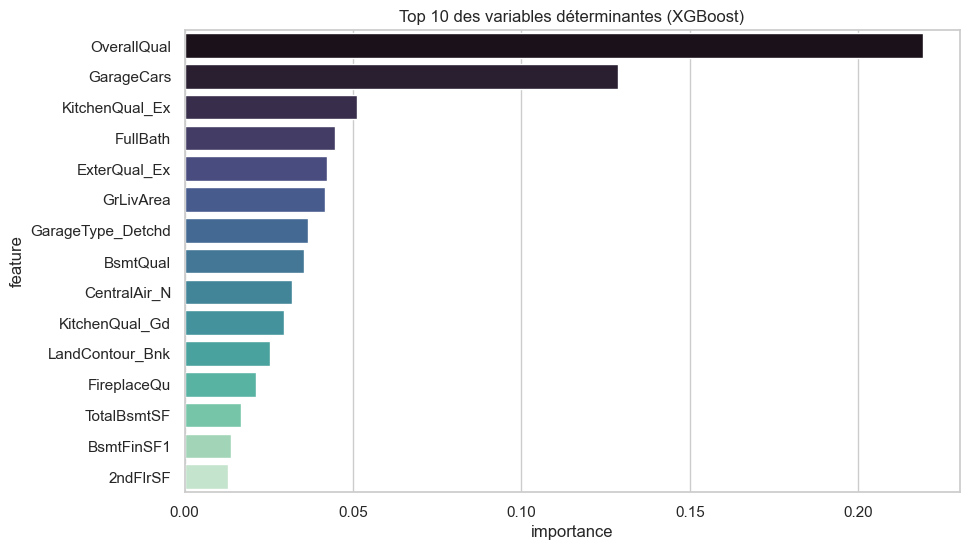

In [17]:
importances = pd.DataFrame({
    'feature': X_final.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature', palette='mako')
plt.title('Top 10 des variables déterminantes (XGBoost)')
plt.show()